In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='PYTORCH_NOTEBOOKS/Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='PYTORCH_NOTEBOOKS/Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: PYTORCH_NOTEBOOKS/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: PYTORCH_NOTEBOOKS/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
## create batch loader

train_loader = DataLoader(train_data, shuffle=True, batch_size=10)
test_loader = DataLoader(test_data, shuffle=True, batch_size=10)

In [6]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
train_data[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

Label : [4 1 5 1 4 7 0 1 8 1] 
Class : ['deer', 'car', 'dog', 'car', 'deer', 'horse', 'plane', 'car', 'ship', 'car']
Image size: torch.Size([10, 3, 32, 32])


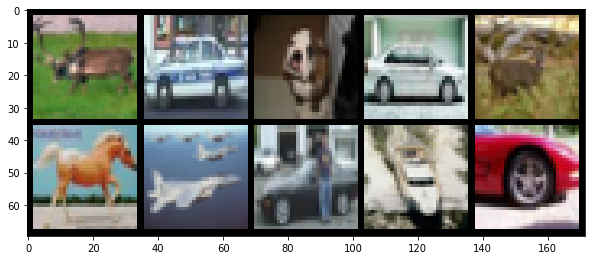

In [8]:
### view the batch of images

for images, label in train_loader:
    break
    
print(f'Label : {label.numpy()} ')
print(f'Class : {[class_names[i] for i in label.numpy()]}')
print(f'Image size: {images.shape}') ## [batch, color channel, height, width]


im = make_grid(images, nrow=5)
plt.figure(figsize=(10,5))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
plt.show()

In [9]:
class CIFARCNNModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv2d1 = nn.Conv2d(3, 6, 3, 1) ## in_channel, out_channel, kernel, stride
        self.conv2d2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 256) ## (((32-2)/2)-2)/2 = 6.5 ~ 6
        self.fc2 = nn.Linear(256, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)
        
        
    def forward(self,x):
        
        x = nn.functional.relu(self.conv2d1(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = nn.functional.relu(self.conv2d2(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 6*6*16)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.log_softmax(x, dim=1)
        
        return x
        

In [10]:
model = CIFARCNNModel()

model

CIFARCNNModel(
  (conv2d1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2d2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
### check the total number of parameters

parameters = [ p.numel() for p in model.parameters()]
total_parameters = sum(parameters)

print(f'{parameters}')
print(f'total: {total_parameters}')

[162, 6, 864, 16, 147456, 256, 30720, 120, 10080, 84, 840, 10]
total: 190614


In [13]:
### training the model

epochs = 10

train_loss = []
test_loss = []

train_correct = []
test_correct = []

for i in range(epochs):
    
    train_corr = 0
    test_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b+=1
        
        y_predict = model(X_train)
        loss = criterion(y_predict, y_train)
        
        predicted_label = torch.max(y_predict,1)[1]
        train_corr += (predicted_label == y_train).sum()
        
        if b%1000 == 0:
            print(f'Epoch:{i} \t Batch:{b} \t Loss: {loss.item()} \t Accuracy:{train_corr.item()*100/(10*b):7.3f}')
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss.append(loss.item())
    train_correct.append(train_corr)

    
    ### test loader
    with torch.no_grad():
        
        for b, (X_test, y_test) in enumerate(test_loader):
            y_test_pred = model(X_test)
            
            test_prediction = torch.max(y_test_pred,1)[1]
            test_corr += (test_prediction == y_test).sum()
            
        test_losses = criterion(y_test_pred, y_test)
        test_loss.append(test_losses.item())
        test_correct.append(test_corr)
        

Epoch:0 	 Batch:1000 	 Loss: 2.6142985820770264 	 Accuracy: 20.380
Epoch:0 	 Batch:2000 	 Loss: 1.9445422887802124 	 Accuracy: 27.430
Epoch:0 	 Batch:3000 	 Loss: 3.2547690868377686 	 Accuracy: 31.183
Epoch:0 	 Batch:4000 	 Loss: 2.3152122497558594 	 Accuracy: 33.903
Epoch:0 	 Batch:5000 	 Loss: 2.055105209350586 	 Accuracy: 35.882
Epoch:1 	 Batch:1000 	 Loss: 3.3161003589630127 	 Accuracy: 48.030
Epoch:1 	 Batch:2000 	 Loss: 1.683099389076233 	 Accuracy: 48.790
Epoch:1 	 Batch:3000 	 Loss: 2.067500591278076 	 Accuracy: 49.287
Epoch:1 	 Batch:4000 	 Loss: 1.9644029140472412 	 Accuracy: 49.705
Epoch:1 	 Batch:5000 	 Loss: 1.081809163093567 	 Accuracy: 50.172
Epoch:2 	 Batch:1000 	 Loss: 3.2118008136749268 	 Accuracy: 52.810
Epoch:2 	 Batch:2000 	 Loss: 1.3334300518035889 	 Accuracy: 53.245
Epoch:2 	 Batch:3000 	 Loss: 1.3763000965118408 	 Accuracy: 53.710
Epoch:2 	 Batch:4000 	 Loss: 2.1704323291778564 	 Accuracy: 53.862
Epoch:2 	 Batch:5000 	 Loss: 1.7654845714569092 	 Accuracy: 54.174

In [14]:
## save the model

torch.save(model.state_dict(),'cifar_cnn.pt')

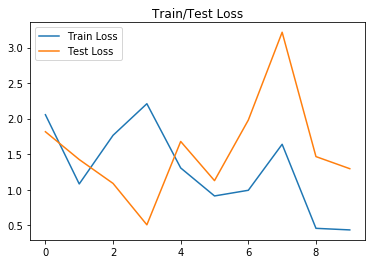

In [15]:
### plot the loss

plt.plot(train_loss,label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.title("Train/Test Loss")
plt.legend()
plt.show()

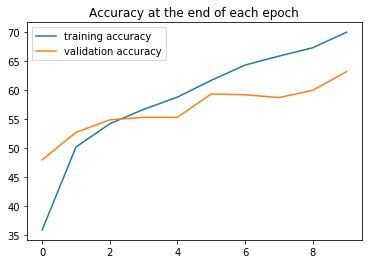

In [16]:
plt.plot([t.numpy()/500 for t in train_correct], label='training accuracy')
plt.plot([t.numpy()/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [17]:
print(test_correct)
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

[tensor(4796), tensor(5269), tensor(5486), tensor(5527), tensor(5528), tensor(5931), tensor(5917), tensor(5869), tensor(5993), tensor(6315)]

Test accuracy: 63.150%


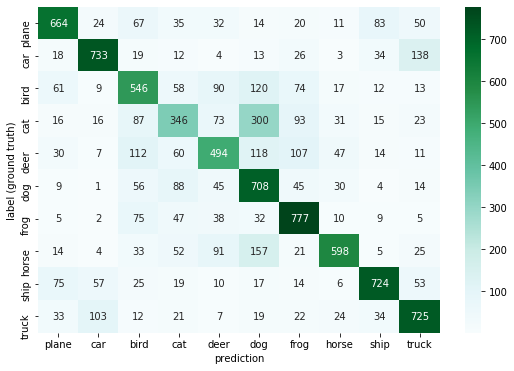

In [18]:
from sklearn.metrics import confusion_matrix

# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)

plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();